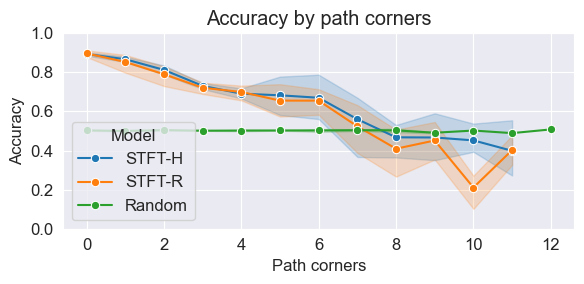

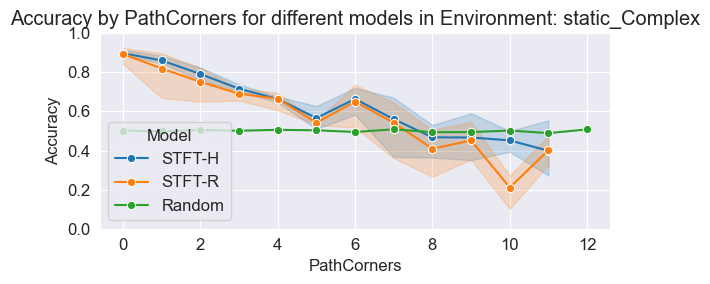

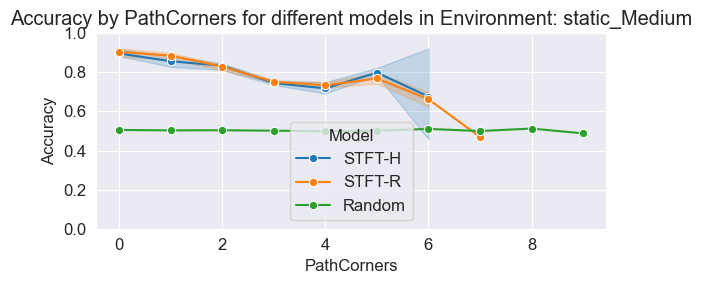

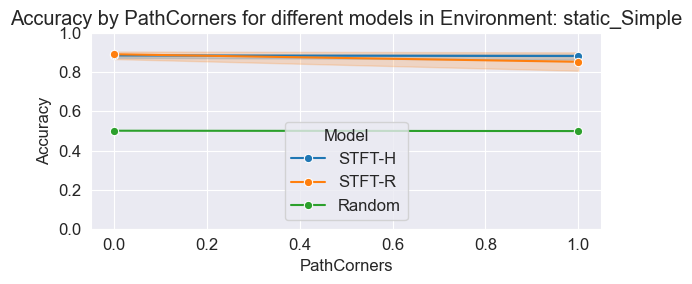

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import seaborn as sns
from parse_name import parse_filename

base_path = r"../logs"
files = glob.glob(f"{base_path}/*.csv")
MAX_STEPS = 1000
spl_totals = []

for file in files:
    metadata = parse_filename(file)

    df = pd.read_csv(file, sep=";", decimal=",")
    string_cols = ["ClipName"]
    for col in df.columns:
        if col not in string_cols:
            df[col] = pd.to_numeric(df[col], errors="coerce")

    shortest_path = df.groupby("Episode")["PathLength"].first()
    df["FullPath"] = shortest_path

    # Compute absolute difference for target angle and predicted angle
    df["Accuracy"] = (df["ActionAngle"] - df["AngleToTarget"]).abs()

    # Correct angles that wrap around
    df.loc[df["Accuracy"] > 1, "Accuracy"] = 2 - df["Accuracy"]

    # Compute difference to accuracy
    df["Accuracy"] = 1 - df["Accuracy"]

    # Calculate accuracy for each PathCorners value
    accuracy = df.groupby("PathCorners")["Accuracy"].mean()

    model = metadata.model
    if "rect" in model:
        model = "STFT-R"
    elif "hanning" in model:
        if "dynamic" in model:
            model = "STFT-H dynamic"
            continue
        else:
            model = "STFT-H"
    elif "random" in model:
        model = "Random"
    environment = metadata.scene

    for index, value in accuracy.items():
        if index == 0:
            # Zeroth index has garbage data
            continue
        else:
            i = index-2
        spl_totals.append({"Environment": environment, "Model": model, "PathCorners": i, "Accuracy": value})

# Convert the list of dictionaries to a DataFrame
df_totals = pd.DataFrame(spl_totals)


font_size = 12
plt.rcParams.update({'font.size': font_size})


# Plot avg of all envs
plt.figure(figsize=(6, 3))
hue_order = ["STFT-H", "STFT-R", "Random"]
sns.lineplot(data=df_totals, x="PathCorners", y="Accuracy", hue="Model", marker='o', hue_order=hue_order)
plt.title(f"Accuracy by path corners")
plt.xlabel("Path corners")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.grid(True)
plt.tight_layout()
plt.savefig(f"accuracy_by_pathcorners.png")
plt.savefig(f"accuracy_by_pathcorners.pdf")
plt.show()

# Get unique environments
environments = df_totals["Environment"].unique()

# Plot a line plot for each environment with seaborn
for env in environments:
    plt.figure(figsize=(6, 3))
    sns.lineplot(data=df_totals[df_totals["Environment"] == env], x="PathCorners", y="Accuracy", hue="Model", marker='o', hue_order=hue_order)
    plt.title(f"Accuracy by PathCorners for different models in Environment: {env}")
    plt.xlabel("PathCorners")
    plt.ylabel("Accuracy")
    plt.ylim(0, 1)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"accuracy_by_pathcorners_{env}.png")
    plt.show()